In [87]:
# https://medium.com/@maryamuzakariya/project-predict-stock-prices-using-random-forest-regression-model-in-python-fbe4edf01664#:~:text=The%20random%20forest%20regression%20model,based%20on%20the%20predicted%20values
# 

# Data Manipulation
import pandas as pd
import numpy as np

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [88]:
def prepare_dataset(path = 'data/AAPL_data.csv', select_feature = True, start_date = '2021-12-29'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

    if select_feature:
        selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
        basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']
        X = X[selected_features + basic_features]

    return X, y

In [89]:
X_pandas, y = prepare_dataset(select_feature=False)
X = np.array(X)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [90]:
# Convert data to float32 for PyTorch
X = X.astype(np.float32)

# Split training and validation data
split = int(0.8 * len(X))
X_train = X[:split]
X_valid = X[split:]

y_train = y[:split].reshape(-1, 1)
y_valid = y[split:].reshape(-1, 1)

# scale data
t_scaler = MinMaxScaler(feature_range=(-1, 1))
v_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = t_scaler.fit_transform(X_train)
X_valid = v_scaler.fit_transform(X_valid)

In [91]:
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by current forest, and the param need to be tuned to find the best 
# for our current dataset
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [92]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [93]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [94]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   2.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   1.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   2.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   1.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   2.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   3.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   3.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   3.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   3.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   3.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   3.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   0.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   1.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   2.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   2.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   2.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   2.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   2.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   4.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   4.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=   2.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=   2.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=   3.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.3s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   2.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   3.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   1.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   1.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   1.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   2.1s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.0s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   4.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.6s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.5s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   1.2s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   2.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.7s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   2.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.8s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.9s


/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   2.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=True, max_depth=40

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [95]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [96]:
model = RandomForestRegressor(n_estimators=1600, min_samples_split=10, \
        min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=True,)

In [97]:
model.fit(X_train, y_train)

/var/folders/f4/d26fc2lx7y5d0rs_6sbh_b2h0000gn/T/ipykernel_18916/180087699.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                      n_estimators=1600)

In [98]:
predict = model.predict(X_valid)

In [99]:
predict

array([ 0.18939554,  0.06274121,  0.06037843,  0.1695471 ,  0.10780601,
       -0.06322596, -0.11507766, -0.23290231, -0.20449812, -0.14947064,
       -0.1460814 , -0.42603114, -0.30864902, -0.07328322,  0.07146618,
        0.3897821 ,  0.60058731])

In [100]:
y_predict = np.where(predict > 0, 1, -1)

In [101]:
print(metrics.classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

          -1       0.67      0.55      0.60        11
           1       0.38      0.50      0.43         6

    accuracy                           0.53        17
   macro avg       0.52      0.52      0.51        17
weighted avg       0.56      0.53      0.54        17



In [102]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [103]:
importances

array([1.20817631e-02, 1.32651513e-02, 1.78265308e-02, 8.64623223e-03,
       5.47163822e-05, 4.87992986e-04, 5.14464791e-03, 1.67668657e-02,
       6.37092774e-03, 1.01904474e-02, 1.38891467e-03, 1.03130811e-02,
       7.56379272e-04, 2.49723495e-03, 1.80859316e-03, 0.00000000e+00,
       8.91523500e-03, 1.04338504e-02, 1.01380100e-02, 7.39527891e-03,
       1.14213158e-02, 5.75959100e-03, 2.07969841e-02, 2.01111169e-02,
       1.17708327e-02, 1.49817860e-02, 2.45565119e-02, 1.28070371e-02,
       1.74498373e-02, 6.44302291e-03, 6.68313323e-03, 0.00000000e+00,
       1.17276723e-03, 1.53037446e-02, 1.49921168e-02, 2.12225461e-02,
       1.17584025e-02, 9.78638389e-03, 0.00000000e+00, 2.01257421e-03,
       4.21363901e-03, 7.29739662e-03, 1.51208369e-02, 4.23211971e-03,
       6.40626356e-03, 1.38122016e-02, 6.49316211e-03, 4.86359702e-03,
       1.00133016e-02, 9.06949502e-03, 2.01624591e-02, 1.61250864e-02,
       8.60737577e-03, 1.80261297e-02, 7.36156097e-03, 6.70643939e-03,
      

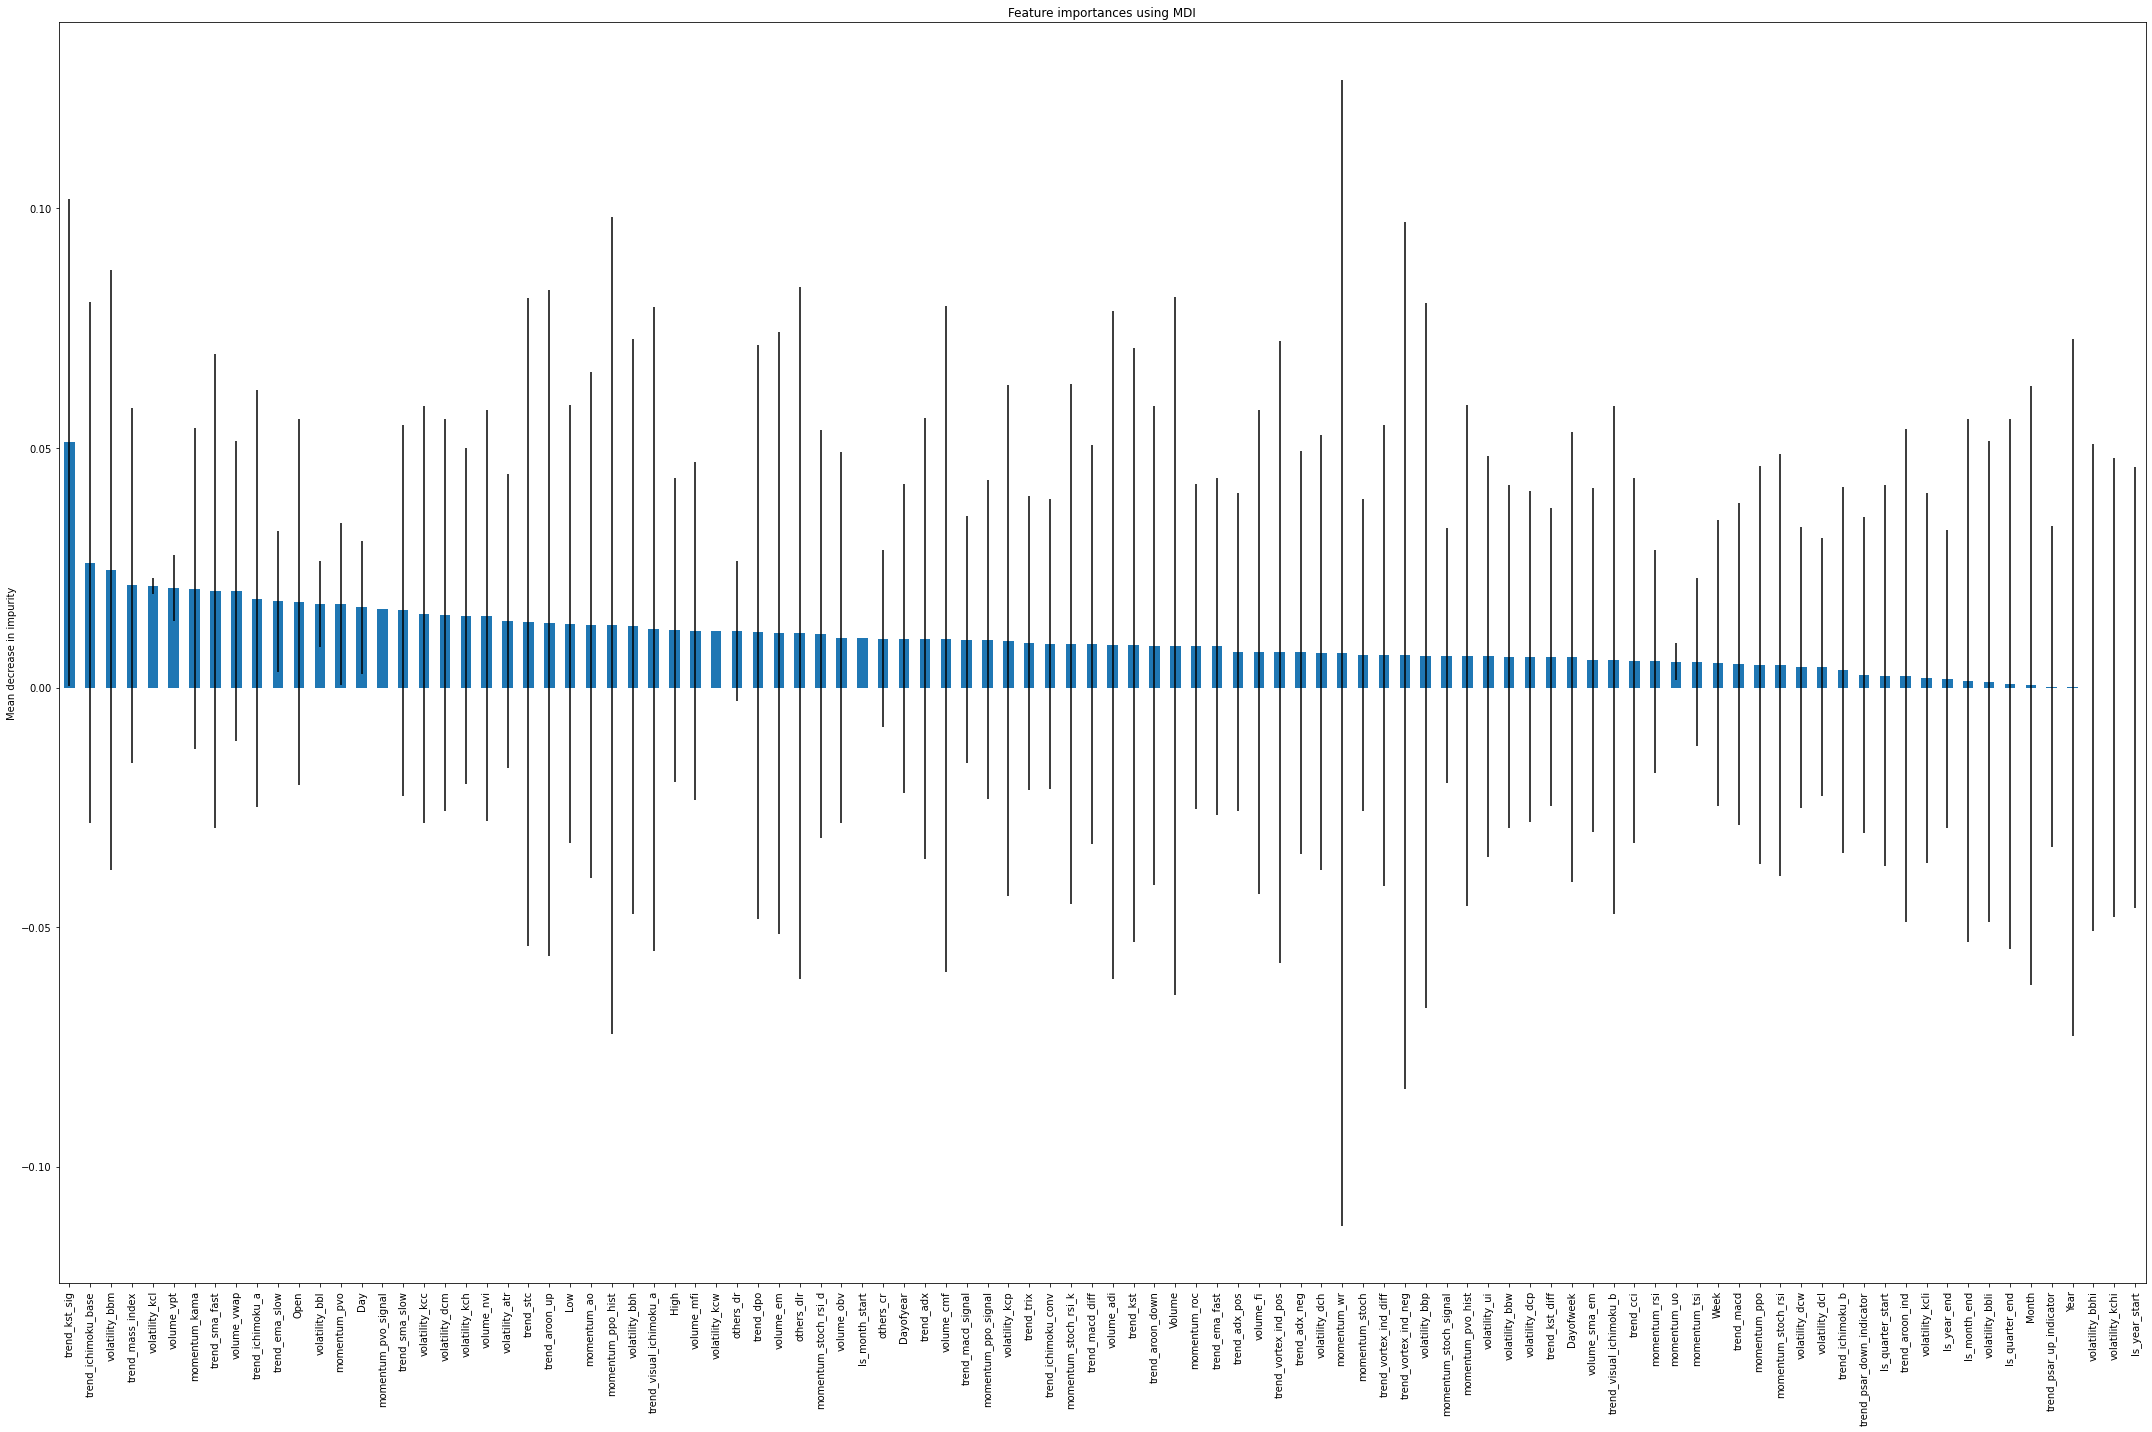

In [108]:
feature_names = [i for i in X_pandas.columns]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(30,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [110]:
forest_importances.head(20)

trend_kst_sig          0.051190
trend_ichimoku_base    0.026088
volatility_bbm         0.024557
trend_mass_index       0.021343
volatility_kcl         0.021223
volume_vpt             0.020797
momentum_kama          0.020638
trend_sma_fast         0.020162
volume_vwap            0.020111
trend_ichimoku_a       0.018580
trend_ema_slow         0.018026
Open                   0.017827
volatility_bbl         0.017450
momentum_pvo           0.017404
Day                    0.016767
momentum_pvo_signal    0.016344
trend_sma_slow         0.016125
volatility_kcc         0.015304
volatility_dcm         0.015121
volatility_kch         0.014992
dtype: float64